In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from scipy.optimize import minimize

In [97]:
def sigmoid_squashing(x):
    return 1./(1+np.exp(-x))

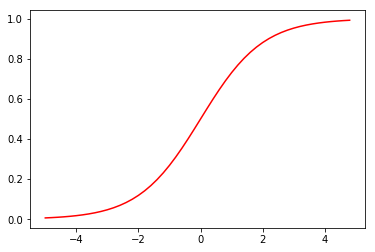

In [98]:
def draw_sigmoid():    
    x = np.arange(-5., 5., 0.2)
    n = len(x)
    y = np.ones(n)

    for i in range(n):
        y[i] = sigmoid_squashing(x[i])

    plt.plot(x, y, 'r')
    plt.show()
draw_sigmoid()

In [99]:
def sigmoid(x):
    return 1./(1+np.exp(-x))
def sigmoid_1(x):
    return math.erf(math.sqrt(math.pi)*x/2)
def sigmoid_2(x):
    return np.tanh(x)
def sigmoid_3(x):
    return (2./math.pi)*np.arcsin(np.tanh((math.pi/2.)*x))
def sigmoid_4(x):
    return x/np.sqrt(1+x**2)
def sigmoid_5(x):
    return (2./math.pi)*np.arctan((math.pi*x/2.))
def sigmoid_6(x):
    return x/(1 + np.absolute(x))

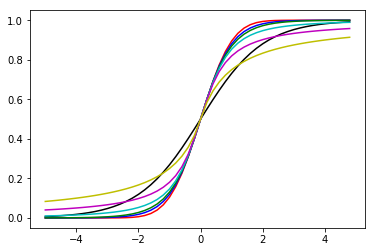

In [100]:
def draw_sigmoid_examples():
    x = np.arange(-5., 5., 0.2)
    n = len(x)
    y = np.ones(n)
    y_1 = np.ones(n)
    y_2 = np.ones(n)
    y_3 = np.ones(n)
    y_4 = np.ones(n)
    y_5 = np.ones(n)
    y_6 = np.ones(n)

    for i in range(n):
        y = sigmoid(x)
        y_1[i] = (sigmoid_1(x[i]) + 1) / 2
        y_2[i] = (sigmoid_2(x[i]) + 1) / 2
        y_3[i] = (sigmoid_3(x[i]) + 1) / 2
        y_4[i] = (sigmoid_4(x[i]) + 1) / 2
        y_5[i] = (sigmoid_5(x[i]) + 1) / 2
        y_6[i] = (sigmoid_6(x[i]) + 1) / 2

    plt.plot(x, y, 'k', x, y_1, 'r', x, y_2, 'b', x, y_3, 'g', x, y_4, 'c', x, y_5, 'm', x, y_6, 'y')
    plt.show()
    
draw_sigmoid_examples()

In [101]:
def kernel(x, y, params, sigma_n):
    diff = np.subtract.outer(x, y)
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) *diff**2)
    value[np.where(diff == 0.0)] += sigma_n**2
    return value

In [102]:
def find_f(K, y, iterations=100):
    n = len(y)
    
    f = np.zeros(n)  
    y_giv_f = np.zeros(n)
    grad = np.ones(n)
    
    for i in range(0, iterations):
        for j in range(n):
            y_giv_f[j] = sigmoid(f[j]*y[j])
            grad[j] = (1-y_giv_f[j])*y[j]
        f = np.array(np.matmul(K, grad)).flatten()
    for j in range(n):
        y_giv_f[j] = sigmoid(f[j]*y[j])
    return f, y_giv_f

In [103]:
def calculate_W(f, y):
    n = len(y)
    W = np.zeros(n)
    for j in range(n):
        sigmoid_v = sigmoid(f[j]*y[j])
        W[j] = y[j]**2 * (1-sigmoid_v)*sigmoid_v
    return np.diag(W)

In [104]:
def calculate_KP(K, W):
    return K + np.linalg.inv(W)

In [105]:
def GP(x_new, x, y, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    
    f, y_giv_f = find_f(K, y)
    W = calculate_W(f, y)
    
    KP = calculate_KP(K, W)

    f_bar = np.matmul(np.matmul(KS, np.linalg.inv(K)), f)    
    var = KSS - KS.dot(np.linalg.inv(KP).dot(KS.T))
    var = np.diagonal(var)
    return(f_bar.squeeze(), var.squeeze())

In [106]:
def pretty_plot(fig, axs, xlim=(-20,20), ylim=(-1.5,1.5), size=(10,10)):
    plt.ylim(ylim)
    plt.xlim(xlim)
    fig.set_size_inches(size)
    plt.show()

In [107]:
def get_low_and_high(y_bar, var):
    sigma = np.sqrt(var)
    y_low = y_bar - 1.96 * sigma
    y_high = y_bar + 1.96 * sigma
    return y_low, y_high

In [108]:
def optimize_theta(x, y, kernel, params_0=[0.1, 0.1], sigma_n=0.1):
    def log_pY(theta):
        K = np.matrix(kernel(x, x, theta, sigma_n))
        f, y_giv_f = find_f(K, y, 100)
        W = calculate_W(f, y)
        inv_k = np.linalg.inv(K)
        log_k = np.log(np.linalg.det(K) * np.linalg.det(inv_k+W))
        Y_giv_f = np.prod(y_giv_f)
        output = 0.5 * np.matmul(np.matmul(f.T, inv_k),f)
        output += 0.5 * log_k
        output -= np.log(Y_giv_f)
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]

In [109]:
x_1 = np.random.choice(np.linspace(-12.5, -7.5, 20), 10, replace=False)
x_2 = np.random.choice(np.linspace(-2.5, 2.5, 20), 5, replace=False)
x_3 = np.random.choice(np.linspace(7.5, 12.5, 20), 10, replace=False)
x = np.concatenate((x_1, x_2, x_3), axis=0)
y = -1 * np.ones(len(x))
y[np.where(abs(x)<3)] = 1

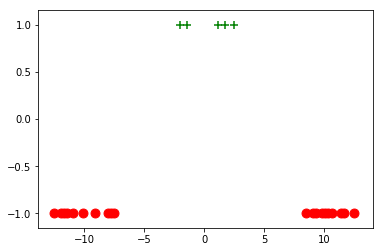

In [110]:
def show_plot():
    for i in range(len(x)):
        if y[i] > 0:
            plt.scatter(x[i], y[i], 80, marker='+', color='g')
        else:
            plt.scatter(x[i], y[i], 80, marker='o', color='r')
    plt.show()
show_plot()

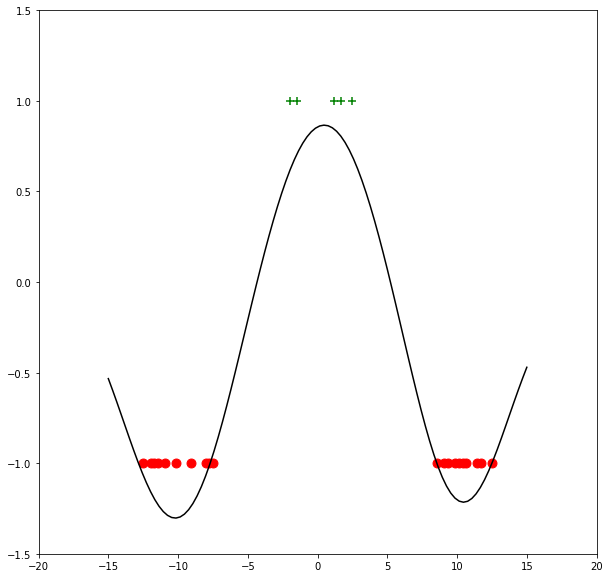

In [111]:
x_new = np.linspace(-15, 15, 100)
params_0 = [.4, 5]
sigma_n = 0.1
theta = optimize_theta(x, y, kernel, params_0=params_0, sigma_n=sigma_n)
y_bar, var = GP(x_new, x, y, kernel, theta)

fig, axs = plt.subplots(1, 1)
for i in range(len(x)):
    if y[i] > 0:
        axs.scatter(x[i], y[i], 80, marker='+', color='g')
    else:
        axs.scatter(x[i], y[i], 80, marker='o', color='r')
axs.plot(x_new, y_bar,  color='k')
pretty_plot(fig, axs)

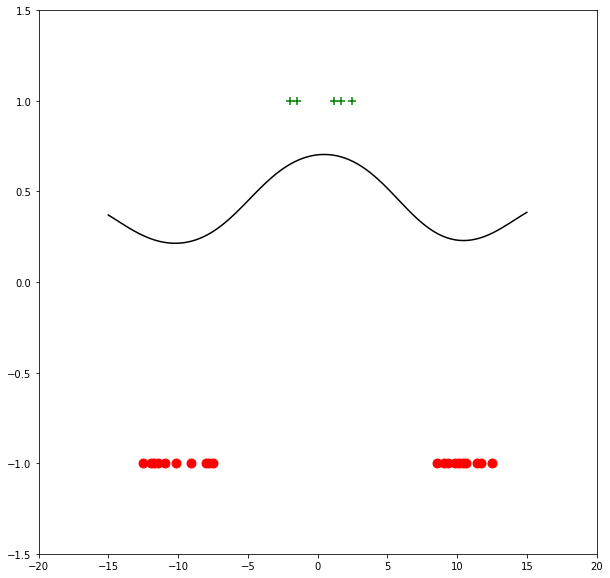

In [112]:
prob = np.zeros(len(y_bar))
for i in range(len(y_bar)):
    prob[i] = sigmoid(y_bar[i])

fig, axs = plt.subplots(1, 1)
for i in range(len(x)):
    if y[i] > 0:
        axs.scatter(x[i], y[i], 80, marker='+', color='g')
    else:
        axs.scatter(x[i], y[i], 80, marker='o', color='r')
axs.plot(x_new, prob,  color='k')
pretty_plot(fig, axs)